# Set up

In [1]:
# update path with data dir
import sys
sys.path.append('../../data/')

In [2]:
import warnings
# warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import patsy
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Getting data

In [4]:
file_name = '../csvs/element_gameweek_features_v03.csv'

In [5]:
element_gameweek_df = pd.read_csv(file_name)

In [6]:
current_event = 20

In [7]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
]

In [8]:
element_gameweek_df.fillna(0, inplace=True)

In [9]:
element_gameweek_df.head()

,safe_web_name,element,event,fixture,team,opposition_team,was_home,element_type,value,is_sunday,...,rolling_var_total_points_against_opposition_team_element_type,rolling_avg_total_points_home,rolling_var_total_points_home,rolling_avg_total_points_against_opposition_ground_element_type,rolling_var_total_points_against_opposition_ground_element_type,total_points,expected_avg_total_points_against_opposition_team,expected_var_total_points_against_opposition_team,expected_avg_total_points_at_ground,expected_var_total_points_at_ground
0,cech,1,1,1,1,13,1,1,50,1,...,0.0,0.0,0.0,0.0,0.0,3,0.000000,0.000000,0.000000,0.0
1,cech,1,2,14,1,6,0,1,50,0,...,0.0,0.0,0.0,0.0,0.0,3,0.681818,0.000000,0.000000,0.0
2,cech,1,3,21,1,19,1,1,50,0,...,8.0,3.0,0.0,0.0,0.0,3,3.750000,0.000000,3.000000,0.0
3,cech,1,4,33,1,5,0,1,50,1,...,11.0,3.0,0.0,6.0,0.0,1,4.493304,0.000000,4.901786,0.0
4,cech,1,5,46,1,15,0,1,50,0,...,49.0,3.0,0.0,2.0,0.0,2,3.663651,5.929855,1.332237,0.0


In [10]:
element_gameweek_df = element_gameweek_df[element_gameweek_df['rolling_avg_minutes_element_p3'] >= 60]

# Modelling data

## Splitting data

In [11]:
last_train_event = 15

In [12]:
test_fold = [-1 if i <= last_train_event else 0 for i in element_gameweek_df['event']]
ps = PredefinedSplit(test_fold)

In [13]:
for train_index, test_index in ps.split():
    element_gameweek_df_train, element_gameweek_df_test = \
    element_gameweek_df.iloc[train_index], element_gameweek_df.iloc[test_index]

## Building model

In [14]:
formula = \
'total_points ~ C(element) + C(element_type) + C(team) + C(opposition_team) + ' + \
' + '.join([i for i in element_gameweek_df.columns if i not in
 [
     'safe_web_name',
     'element',
     'event',
     'fixture',
     'team',
     'opposition_team',
     'element_type',
     'rolling_avg_attempted_passes_element',
     'rolling_var_total_points_against_opposition_team',
     'rolling_var_total_points_own_team',
     'rolling_var_total_points_opposition_team',
     'rolling_var_total_points_element_type',
     'rolling_var_total_points_against_opposition_team_element_type',
     'expected_var_total_points_against_opposition_team',
     'expected_var_total_points_at_ground',
     'rolling_avg_total_points_home',
     'rolling_var_total_points_home',
     'rolling_avg_total_points_against_opposition_ground_element_type',
     'rolling_var_total_points_against_opposition_ground_element_type',
     'total_points'
 ]])

In [15]:
print(formula)

total_points ~ C(element) + C(element_type) + C(team) + C(opposition_team) + was_home + value + is_sunday + is_weekday + is_late + is_early + rolling_avg_total_points_element + rolling_var_total_points_element + rolling_max_total_points_element + rolling_avg_minutes_element_p3 + rolling_avg_bps_element + rolling_avg_bonus_element + rolling_avg_goals_scored_element + rolling_avg_minutes_element + rolling_avg_clean_sheets_element + rolling_avg_completed_passes_element + rolling_avg_recoveries_element + rolling_avg_assists_element + rolling_avg_key_passes_element + rolling_avg_winning_goals_element + rolling_avg_tackled_element + rolling_avg_dribbles_element + rolling_avg_clearances_blocks_interceptions_element + rolling_avg_big_chances_created_element + rolling_avg_target_missed_element + rolling_avg_fouls_element + rolling_avg_tackles_element + rolling_avg_open_play_crosses_element + rolling_avg_offside_element + rolling_avg_big_chances_missed_element + rolling_avg_saves_element + rolli

In [16]:
y, X = patsy.dmatrices(formula, element_gameweek_df, return_type='matrix')

In [17]:
for train_index, test_index in ps.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

## Tuning model

In [78]:
n_estimators = [98]
min_samples_split = [0.015]
min_samples_leaf = [0.0125, 0.0145, 0.01475]

parameters = {
    'n_estimators': n_estimators,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

In [79]:
gs_model = GridSearchCV(
    RandomForestRegressor(random_state=0),
    parameters,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
    refit=False,
    cv=ps,
    error_score=100, n_jobs=1, verbose=1)
gs_model.fit(X, y.ravel())

Fitting 1 folds for each of 3 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.7s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=100,
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=0,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=1,
           

In [80]:
gs_model_df = pd.DataFrame(gs_model.cv_results_)[[
    'param_n_estimators','param_min_samples_split','param_min_samples_leaf',
    'split0_test_neg_mean_absolute_error',
    'split0_test_neg_mean_squared_error'
]]
gs_model_df

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
0,98,0.015,0.0125,-2.169922,-9.382441
1,98,0.015,0.0145,-2.168869,-9.370348
2,98,0.015,0.01475,-2.168869,-9.370348


In [81]:
gs_model_df[
    gs_model_df['split0_test_neg_mean_squared_error'] == \
    gs_model_df['split0_test_neg_mean_squared_error'].max()]


,param_n_estimators,param_min_samples_split,param_min_samples_leaf,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
1,98,0.015,0.0145,-2.168869,-9.370348
2,98,0.015,0.01475,-2.168869,-9.370348


# Evaluating model

In [82]:
model = RandomForestRegressor(random_state=0, n_estimators=98, min_samples_leaf=0.0145, min_samples_split=0.015)
model.fit(X_train, y_train.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=0.0145, min_samples_split=0.015,
                      min_weight_fraction_leaf=0.0, n_estimators=98,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [83]:
# get predictions for test set
y_pred = model.predict(X_test).flatten()

# calculate cross entropy loss for test set
test_loss = (mean_absolute_error(y_test, y_pred), mean_squared_error(y_test, y_pred))
test_loss

(2.168869381092777, 9.370347677324274)

In [84]:
pd.Series(y_pred).describe()

count    948.000000
mean       2.674231
std        0.955052
min        1.053275
25%        1.972478
50%        2.446983
75%        3.320843
max        5.730150
dtype: float64

In [85]:
# refit model on all data
model_full = RandomForestRegressor(min_samples_leaf=5, random_state=0)
model_full.fit(X, y.ravel())

/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [86]:
# get predictions for whole set
y_pred_full = model_full.predict(X).flatten()

# calculate cross entropy loss for test set
test_loss_full = (mean_absolute_error(y, y_pred_full), mean_squared_error(y, y_pred_full))
test_loss_full

(1.332298737370611, 3.7978522052829025)

In [87]:
pd.Series(y_pred_full).describe()

count    3644.000000
mean        2.888850
std         1.681118
min        -0.713539
25%         1.729733
50%         2.502757
75%         3.761060
max        10.729008
dtype: float64

In [88]:
abs(pd.Series(y.ravel()) - pd.Series(y_pred_full)).describe()

count    3644.000000
mean        1.332299
std         1.422458
min         0.000007
25%         0.414671
50%         0.907904
75%         1.759408
max        12.774762
dtype: float64

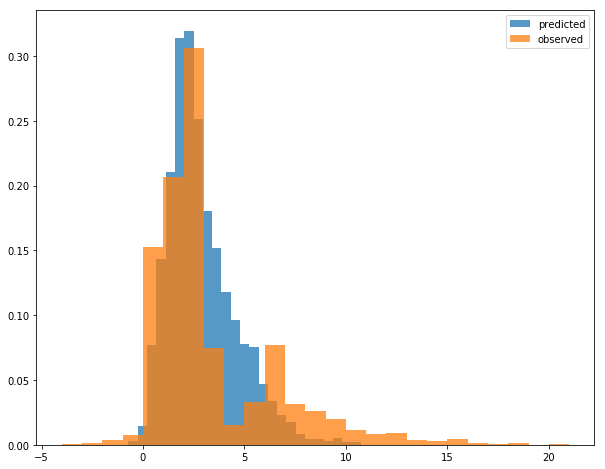

In [89]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(y_pred_full), bins=25, alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y.ravel()), bins=25, alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

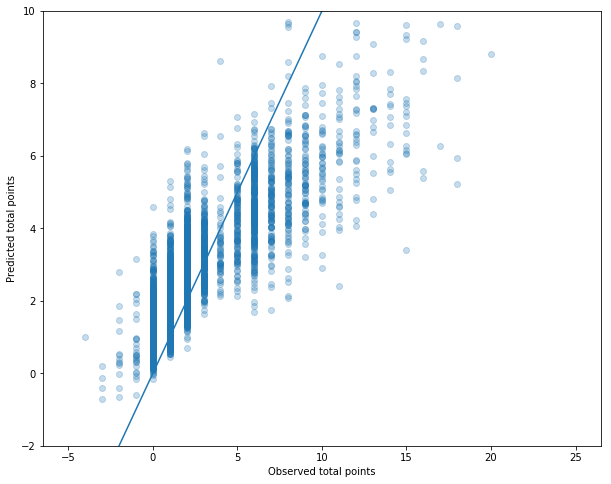

In [91]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y.ravel()), pd.Series(y_pred_full), alpha=0.25)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-2, 10))
plt.show()